In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#Read the data pulled in from the website
df = pd.read_csv('../data/complete.csv')
df.head()

,title,selftext,subreddit,created_utc
0,ELI5 How do hand-cranked mobile shelving units...,I work in an office where these gigantic shelv...,explainlikeimfive,1645817645
1,ELI5 What made whale oil desirable as opposed ...,Wasn't sure whether to tag this as biology or ...,explainlikeimfive,1645789811
2,ELI5 how is a transistor such a fast switch,Our CPUs have billions of transistors and each...,explainlikeimfive,1645289010
3,ELI5 What is CRISPR exactly and how far could ...,[removed],explainlikeimfive,1645278569
4,ELI5: Why can't we customize our phone/mobile ...,"Like the title says, I love tech but know next...",explainlikeimfive,1645121925


In [3]:
#Check for shape of the DataFrame
df.shape

(1997, 4)

In [4]:
#Check for duplicates
df.drop_duplicates()

,title,selftext,subreddit,created_utc
0,ELI5 How do hand-cranked mobile shelving units...,I work in an office where these gigantic shelv...,explainlikeimfive,1645817645
1,ELI5 What made whale oil desirable as opposed ...,Wasn't sure whether to tag this as biology or ...,explainlikeimfive,1645789811
2,ELI5 how is a transistor such a fast switch,Our CPUs have billions of transistors and each...,explainlikeimfive,1645289010
3,ELI5 What is CRISPR exactly and how far could ...,[removed],explainlikeimfive,1645278569
4,ELI5: Why can't we customize our phone/mobile ...,"Like the title says, I love tech but know next...",explainlikeimfive,1645121925
...,...,...,...,...
1992,I measured the screw in the calipers and the d...,NaN,AskEngineers,1644800846
1993,Can some please explain why all four wheels of...,Just trying to understand why all four wheels ...,AskEngineers,1644800765
1994,"Engineers in Ontario. What’s your Field, Exper...","Me - Mechanical Design, 4 years, 50k.",AskEngineers,1644800641
1995,Tesla Interview Progress - Giga TX,After passing many one-on-one interviews and a...,AskEngineers,1644799761


Since the two dataframes are of the same shape, no rows were dropped as duplicates, i.e. there are no duplicates on the dataframe. 

In [5]:
df.groupby('subreddit').count()

,title,selftext,created_utc
subreddit,,,
AskEngineers,999,932,999
explainlikeimfive,998,860,998


In [6]:
#Check for nulls in the dataframe
df.isnull().sum()

title            0
selftext       205
subreddit        0
created_utc      0
dtype: int64

In [7]:
#Check for nulls per subreddit
df[df['selftext'].isnull()].groupby('subreddit').count()

,title,selftext,created_utc
subreddit,,,
AskEngineers,67,0,67
explainlikeimfive,138,0,138


The plan is to use both *title* and *selftext* for the prediction model. It is for this reason that, whenever there is missing or incomplete *selftext* entry, text of *title* is examined to to keep the row with sufficient overall text, and drop those without sufficient text. 

In [8]:
#Check the length of text in the title section of these rows, that have a NaN value for selftext 
df[df['selftext'].isnull()]['title'].map(len).sort_values(ascending=False)

445     298
92      280
367     277
1968    271
1485    268
       ... 
1103     26
508      26
1427     26
1936     24
1623      4
Name: title, Length: 205, dtype: int64

Looks like most of the rows with missing selftext have title text length more than 24, which is enough to work off for the model. Hence, it will be okay to replace these missing values with blanks/empty string. But there is one post that has no selftext and just 4 letters/characters in the title. 

In [9]:
#Check the title with 4 letters/characters
df.iloc[1623]

title                  Help
selftext                NaN
subreddit      AskEngineers
created_utc      1645216848
Name: 1623, dtype: object

The only text in that post is 'Help', which is also part of stopwords = 'english'. It will be dropped if stopwords are dropped in the model later. Hence, the row is being dropped for no value addition.

In [10]:
#Drop row with index 1623
df.drop(index=1623,inplace=True)

In [11]:
#Replace NaN's with ''
df['selftext'].fillna(' ',inplace=True)

In [12]:
#Check the DataFrame again for null values
df.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

Because a row was dropped, it makes indexing difficult. Hence, the following code is used to reset index. 

In [13]:
df.reset_index(drop=True,inplace=True)

Another step in data cleaning is required for rows with selftext '[removed]'. These are the comments removed or deleted. 

In [14]:
df[df['selftext'] == '[removed]'].groupby('subreddit').count()

,title,selftext,created_utc
subreddit,,,
AskEngineers,111,111,111
explainlikeimfive,196,196,196


In [15]:
df.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

In [16]:
df.shape

(1996, 4)

In [17]:
#Check the length of text in the title section of these rows, that have '[removed]' for selftext 
df[df['selftext'] == '[removed]']['title'].map(len).sort_values(ascending=False)

1348    299
668     282
549     274
886     269
866     269
       ... 
1845      6
1366      4
1781      4
1545      4
1415      3
Name: title, Length: 307, dtype: int64

There are 307 rows with '[removed]' *selftext*. Some of the titles with these selftexts are relatively short length of text for Natural Language Processing model to work off of. Replacing the *selftext* with blank string will be helpful, only after checking that we have enough text to work our model off of those rows.

In [18]:
indices = df[df['selftext'] == '[removed]']['title'].map(lambda x: len(x.split())).sort_values(ascending=True).head(14).index

In [19]:
indices

Int64Index([1625, 1366, 1365, 1089, 1415, 1545, 1781, 1914, 1053, 1845,  623,
            1709, 1101, 1696],
           dtype='int64')

In [20]:
df.iloc[indices]

,title,selftext,subreddit,created_utc
1625,Finally!!,[removed],AskEngineers,1645214401
1366,Math,[removed],AskEngineers,1645606286
1365,Intern,[removed],AskEngineers,1645606491
1089,Startups,[removed],AskEngineers,1646024695
1415,Job,[removed],AskEngineers,1645558890
1545,Jobs,[removed],AskEngineers,1645359568
1781,Idea,[removed],AskEngineers,1645036003
1914,question,[removed],AskEngineers,1644880587
1053,Hello!,[removed],AskEngineers,1646079891
1845,Advice,[removed],AskEngineers,1644962570


In [21]:
#List of stopwords that may or may not be excluded from the model
stopwords = stopwords.words('english')

In [22]:
#Check if the single words fall under the stopwords umbrella
df.iloc[indices]['title'].map(lambda x: True if x in stopwords else False)

1625    False
1366    False
1365    False
1089    False
1415    False
1545    False
1781    False
1914    False
1053    False
1845    False
623     False
1709    False
1101    False
1696    False
Name: title, dtype: bool

As none of the text in rows with with single words in *title* column and '[removed]' in *selftext* column fall under stopwords umbrella, these rows can be used for natural language processing and need not be dropped. And the rows with '[removed]' can be replaced by blank string.

In [23]:
df.replace(to_replace='[removed]',value=' ',inplace=True)

In [24]:
#Check if the replace went through
df[df['subreddit'] == '[removed]']

,title,selftext,subreddit,created_utc


In [25]:
df.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

In [26]:
#Check the shape of the dataframe
df.shape

(1996, 4)

**Removing URL from *selftext* column**

In [27]:
df['selftext'] = df['selftext'].str.replace('https:\/\/',' ',regex=True)

In [28]:
#Check if https has been removed
df[df['selftext'].str.contains('https')]

,title,selftext,subreddit,created_utc


In [29]:
#Create a new column that combines title and selftext
df['full_text'] = df['title'] + ' ' + df['selftext']

In [30]:
#Check for the new column in the dataframe
df.head()

,title,selftext,subreddit,created_utc,full_text
0,ELI5 How do hand-cranked mobile shelving units...,I work in an office where these gigantic shelv...,explainlikeimfive,1645817645,ELI5 How do hand-cranked mobile shelving units...
1,ELI5 What made whale oil desirable as opposed ...,Wasn't sure whether to tag this as biology or ...,explainlikeimfive,1645789811,ELI5 What made whale oil desirable as opposed ...
2,ELI5 how is a transistor such a fast switch,Our CPUs have billions of transistors and each...,explainlikeimfive,1645289010,ELI5 how is a transistor such a fast switch Ou...
3,ELI5 What is CRISPR exactly and how far could ...,,explainlikeimfive,1645278569,ELI5 What is CRISPR exactly and how far could ...
4,ELI5: Why can't we customize our phone/mobile ...,"Like the title says, I love tech but know next...",explainlikeimfive,1645121925,ELI5: Why can't we customize our phone/mobile ...


Many of the title rows contain 'ELI5', 'ELI5:', 'eli5', 'eli5:', 'AskEngineers' and 'askengineers' which is an abbreviation of the subreddit itself. These prefixes will need to be removed in order to train the model on this data and predict from it.  

In [31]:
df['full_text'].str.contains('ELI5:').sum()

773

773 rows contain the abbreviation of the subreddit. We want words other than the subreddit name to train the model. The following code removes these keywords form the text. 

In [32]:
df['full_text'] = df['full_text'].str.replace('[Ee][Ll][Ii]5[:]?',' ',regex=True)

In [33]:
df[df['full_text'].str.contains('eli5')]

,title,selftext,subreddit,created_utc,full_text


In [34]:
df[df['full_text'].str.contains('ELI5')]

,title,selftext,subreddit,created_utc,full_text


ELI5 or eli5 has been removed from the text.

In [35]:
df[df['full_text'].str.contains('AskEngineer')]

,title,selftext,subreddit,created_utc,full_text
1231,Failure Friday (25 Feb 2022): Break something ...,# Intro\n\nToday's thread is for all the recen...,AskEngineers,1645797617,Failure Friday (25 Feb 2022): Break something ...
1400,Contract Engineer vs. Regular Full-Time (Doing...,***tldr;*** I make $85K/base + $10K other bene...,AskEngineers,1645565455,Contract Engineer vs. Regular Full-Time (Doing...
1623,I kindly ask r/AskEngineers for feedback on a ...,***!DISCLAIMER!***\n\nAlthough this **is a hom...,AskEngineers,1645216014,I kindly ask r/AskEngineers for feedback on a ...
1657,Failure Friday (18 Feb 2022): Break something ...,# Intro\n\nToday's thread is for all the recen...,AskEngineers,1645192818,Failure Friday (18 Feb 2022): Break something ...
1894,Looks like I’m going to be offered 2 jobs. Wha...,Background: 5 years usmc infantry Iraq . PMP B...,AskEngineers,1644902908,Looks like I’m going to be offered 2 jobs. Wha...
1949,Time To Escalate Negotiation Pressure?,My company is about to let their union contrac...,AskEngineers,1644857785,Time To Escalate Negotiation Pressure? My comp...


In [36]:
df[df['full_text'].str.contains('askengineer')]

,title,selftext,subreddit,created_utc,full_text


6 rows contain AskEngineer, which is its subreddit. We need to remove these direct references to the subreddit. 

In [37]:
#Remove the above mentioned words and replace them with '' 
df['full_text'] = df['full_text'].str.replace('[Aa][Ss][Kk][Ee][Nn][Gg][Ii][Nn][Ee]{2}[Rr]',' ',regex=True)

In [38]:
#Check dataframe to see if the replace method worked
df[df['full_text'].str.contains('askengineer')]

,title,selftext,subreddit,created_utc,full_text


In [39]:
#Check dataframe to see if the replace method worked
df[df['full_text'].str.contains('AskEngineer')]

,title,selftext,subreddit,created_utc,full_text


### Remove spaces, tabs and breaklines

In [40]:
def  clean_text(text):
    #substitute non-numeric and non-alphabetic characters with blanks
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    #Substitue tabs, new-lines and whitespaces with blanks
    text = re.sub('\s+',' ',text).strip()
    #Lower case the text and return 
    return text.lower()

In [41]:
df['full_text'] = df['full_text'].map(clean_text)

## Sentiment Analysis

In [42]:
sia = SentimentIntensityAnalyzer()

In [43]:
df['senti_score_comp'] = df['full_text'].map(lambda x: sia.polarity_scores(x)['compound'])
df['senti_score_comp']

0       0.8627
1       0.8316
2      -0.4957
3       0.0000
4       0.9423
         ...  
1991    0.4939
1992    0.0772
1993   -0.1027
1994    0.9341
1995    0.3182
Name: senti_score_comp, Length: 1996, dtype: float64

## Additional columns

In [44]:
#Add column with length of full_text
df['full_text_len'] = df['full_text'].map(len)

In [45]:
#Add column with word count of full_text
df['full_text_word_count'] = df['full_text'].map(lambda x : len(x.split()))

In [46]:
df.drop(columns='created_utc',inplace=True)

In [47]:
df.head()

,title,selftext,subreddit,full_text,senti_score_comp,full_text_len,full_text_word_count
0,ELI5 How do hand-cranked mobile shelving units...,I work in an office where these gigantic shelv...,explainlikeimfive,how do hand cranked mobile shelving units work...,0.8627,445,80
1,ELI5 What made whale oil desirable as opposed ...,Wasn't sure whether to tag this as biology or ...,explainlikeimfive,what made whale oil desirable as opposed to oi...,0.8316,273,51
2,ELI5 how is a transistor such a fast switch,Our CPUs have billions of transistors and each...,explainlikeimfive,how is a transistor such a fast switch our cpu...,-0.4957,367,68
3,ELI5 What is CRISPR exactly and how far could ...,,explainlikeimfive,what is crispr exactly and how far could it go...,0.0000,140,27
4,ELI5: Why can't we customize our phone/mobile ...,"Like the title says, I love tech but know next...",explainlikeimfive,why can t we customize our phone mobile hardwa...,0.9423,404,76


## Exploratory Data Analysis

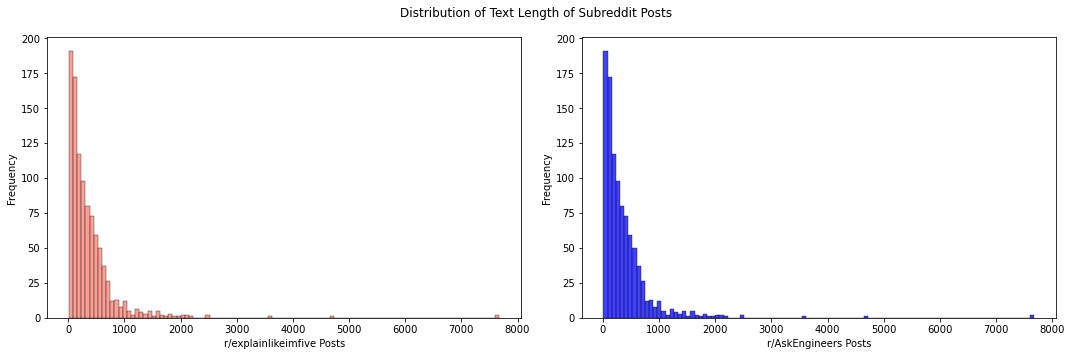

In [48]:
#Plot distribution of length of full text for both subreddits to compare

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df[df['subreddit'] == 'explainlikeimfive']['full_text_len'],ax=axes[0],color='salmon')
axes[0].set_xlabel('r/explainlikeimfive Posts')
axes[0].set_ylabel('Frequency')

sns.histplot(df[df['subreddit'] == 'explainlikeimfive']['full_text_len'],ax=axes[1],color='blue')
axes[1].set_xlabel('r/AskEngineers Posts')
axes[1].set_ylabel('Frequency')

plt.suptitle('Distribution of Text Length of Subreddit Posts')
plt.tight_layout();

The distribution looks fairly similar. No insights comparable insights can be deduced from this. 

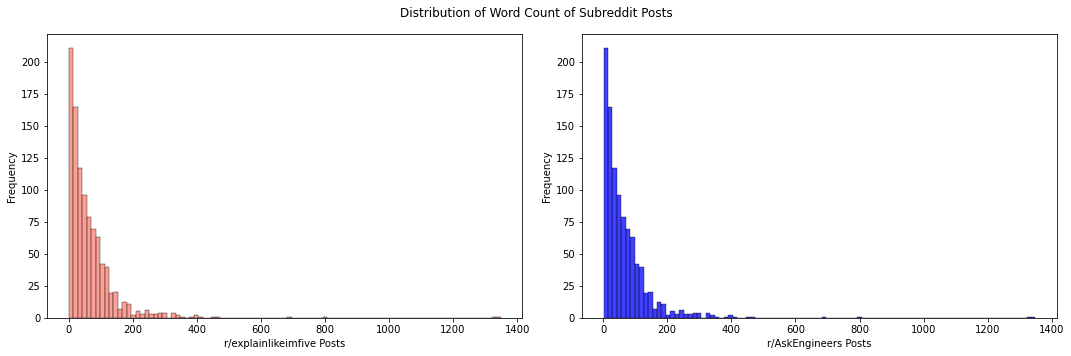

In [49]:
#Plot distribution of word count of full text for both subreddits to compare

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df[df['subreddit'] == 'explainlikeimfive']['full_text_word_count'],ax=axes[0],color='salmon')
axes[0].set_xlabel('r/explainlikeimfive Posts')
axes[0].set_ylabel('Frequency')

sns.histplot(df[df['subreddit'] == 'explainlikeimfive']['full_text_word_count'],ax=axes[1],color='blue')
axes[1].set_xlabel('r/AskEngineers Posts')
axes[1].set_ylabel('Frequency')

plt.suptitle('Distribution of Word Count of Subreddit Posts')
plt.tight_layout();

Again, there is not a lot of difference between the two distributions. 

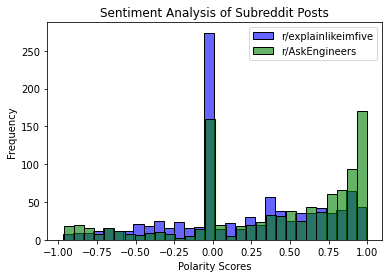

In [50]:
sns.histplot(df[df['subreddit'] == 'explainlikeimfive']['senti_score_comp'],bins=30,color='blue', alpha = 0.6,label='r/explainlikeimfive')
sns.histplot(df[df['subreddit'] == 'AskEngineers']['senti_score_comp'],bins=30,color='green', alpha = 0.6,label='r/AskEngineers')
plt.title('Sentiment Analysis of Subreddit Posts')
plt.xlabel('Polarity Scores')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('../images/sentiment_analysis');

The above plot shows the distribution of Polarity Scores. It looks like for r/explainlikeimfive the polarity scores are centerd around 0, with a slight peak around one, which implies the posts from this subreddit are mostly neutral. 
The polarity scores for r/AskEngineers have an evident peak around 1, with a slight peak at zero.  This implies that posts from this subreddit are majorly positive or neutral. 

## Export DataFrame to .csv

In [51]:
df.to_csv('../data/complete_clean.csv',index=False)